In [1]:
%%javascript
  function ClickConnect() {
    var iconElement = document.getElementById("toggle-header-button");
    if (iconElement) {
    var clickEvent = new MouseEvent ("click", {
        bubbles: true, cancelable: true,
        view: window
      });
    iconElement.dispatchEvent (clickEvent);
    }
  }
  setInterval(ClickConnect, 6000);

<IPython.core.display.Javascript object>

In [2]:
!pip install timm

In [3]:
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.signal
from skimage import color, exposure
from PIL import Image
from tqdm import tqdm
import pandas as pd
import timm
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "xla" if xm.xla_device() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def cargarDataset(ruta_dataset, guardar_ruta, tamanio_imagen=(200, 200), test_size=0.2, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "xla" if xm.xla_device() else "cpu")
    dataset = []
    etiquetas_mapping = {}
    clases = sorted(os.listdir(ruta_dataset))
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}
    for clase in clases:
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]
        with os.scandir(ruta_clase) as entries:
            for entry in entries:
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    imagen_resized = imagen.resize(tamanio_imagen)
                    imagen_array = np.array(imagen_resized) / 255.0
                    imagen_tensor = torch.tensor(imagen_array).float().permute(2, 0, 1).to(device)
                    dataset.append((imagen_tensor, etiqueta_num))
    random.shuffle(dataset)
    torch.save(dataset, guardar_ruta)
    return dataset

In [5]:
def fit(model, dataloader, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = correct_predictions / total_predictions
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

In [8]:
class EfficientNetZero(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=True, freeze=False):
        super().__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=pretrained)
        self.efficientnet.classifier = torch.nn.Linear(self.efficientnet.classifier.in_features, n_outputs)

        if freeze:
            for param in self.efficientnet.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

    def unfreeze(self):
        for param in self.efficientnet.parameters():
            param.requires_grad = True

In [10]:
class EfficientNetTransferLearning(torch.nn.Module):
    def __init__(self, n_outputs=5, pretrained=True, freeze=True):
        super().__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=pretrained)
        self.efficientnet.classifier = torch.nn.Linear(self.efficientnet.classifier.in_features, n_outputs)
        if freeze:
            for name, param in self.efficientnet.named_parameters():
                if 'classifier' not in name:
                    param.requires_grad = False
        else:
            for param in self.efficientnet.parameters():
                param.requires_grad = True
    def forward(self, x):
        return self.efficientnet(x)
    def unfreeze(self):
        for param in self.efficientnet.parameters():
            param.requires_grad = True

# ***Carga del Dataset***

In [6]:
ruta_guardar_dataset = '/content/drive/MyDrive/SIS421/Laboratorio N°3 - SIS421/checkpoints/datasetTF.pt'
ruta_guardar_modelo = '/content/drive/MyDrive/SIS421/Laboratorio N°3 - SIS421/checkpoints/modeloTF.pt'
ruta_dataset = '/content/drive/MyDrive/SIS421/Laboratorio N°3 - SIS421/Plantas'
dataset = cargarDataset(ruta_dataset, guardar_ruta=ruta_guardar_dataset, device=device)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

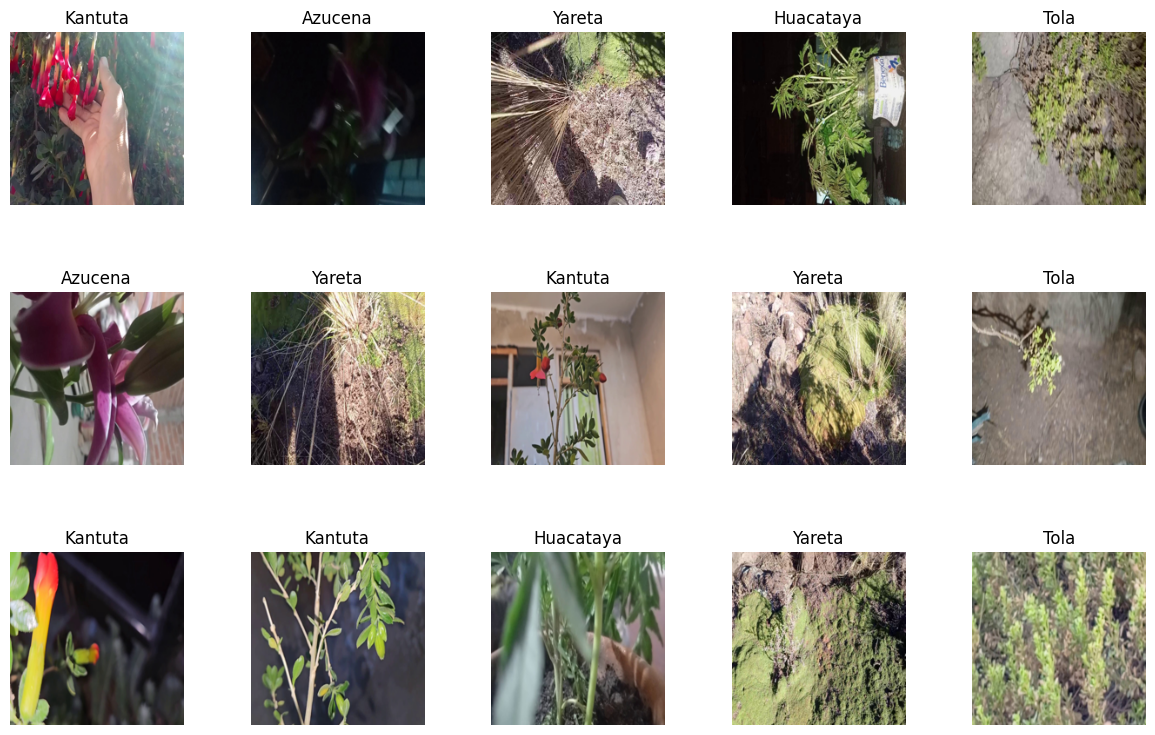

In [7]:
classes = ('Azucena', 'Huacataya', 'Kantuta', 'Tola', 'Yareta')
filas, columnas = 3, 5
plt.figure(figsize=(columnas*3, filas*3))
for fila in range(filas):
    for columna in range(columnas):
        indice = columnas*fila + columna
        plt.subplot(filas, columnas, indice + 1)
        ix = random.randint(0, len(train_dataset)-1)
        img, etiqueta = train_dataset[ix]
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(classes[etiqueta])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# ***Entrenando el Modelo***

In [13]:
model_z = EfficientNetZero(pretrained=False, freeze=False)
model_z.to(device)
fit(model_z, train_loader, epochs=50)

Epoch [1/50], Loss: 0.9358, Accuracy: 0.5804
Epoch [2/50], Loss: 0.4747, Accuracy: 0.8240
Epoch [3/50], Loss: 0.2840, Accuracy: 0.9007
Epoch [4/50], Loss: 0.1917, Accuracy: 0.9311
Epoch [5/50], Loss: 0.1551, Accuracy: 0.9460
Epoch [6/50], Loss: 0.1823, Accuracy: 0.9379
Epoch [7/50], Loss: 0.1380, Accuracy: 0.9511
Epoch [8/50], Loss: 0.1054, Accuracy: 0.9661
Epoch [9/50], Loss: 0.0575, Accuracy: 0.9809
Epoch [10/50], Loss: 0.0636, Accuracy: 0.9789
Epoch [11/50], Loss: 0.0815, Accuracy: 0.9734
Epoch [12/50], Loss: 0.1072, Accuracy: 0.9662
Epoch [13/50], Loss: 0.0760, Accuracy: 0.9770
Epoch [14/50], Loss: 0.0693, Accuracy: 0.9774
Epoch [15/50], Loss: 0.0313, Accuracy: 0.9901
Epoch [16/50], Loss: 0.1312, Accuracy: 0.9585
Epoch [17/50], Loss: 0.0853, Accuracy: 0.9736
Epoch [18/50], Loss: 0.1011, Accuracy: 0.9667
Epoch [19/50], Loss: 0.0741, Accuracy: 0.9776
Epoch [20/50], Loss: 0.0203, Accuracy: 0.9943
Epoch [21/50], Loss: 0.0320, Accuracy: 0.9893
Epoch [22/50], Loss: 0.0294, Accuracy: 0.98

# ***Transfer Learning***

In [14]:
model_tl = EfficientNetTransferLearning(pretrained=True, freeze=True)
model_tl.to(device)
fit(model_tl, train_loader, epochs=50)

Epoch [1/50], Loss: 0.4923, Accuracy: 0.8837
Epoch [2/50], Loss: 0.1939, Accuracy: 0.9541
Epoch [3/50], Loss: 0.1458, Accuracy: 0.9628
Epoch [4/50], Loss: 0.1233, Accuracy: 0.9675
Epoch [5/50], Loss: 0.1010, Accuracy: 0.9744
Epoch [6/50], Loss: 0.0911, Accuracy: 0.9769
Epoch [7/50], Loss: 0.0783, Accuracy: 0.9792
Epoch [8/50], Loss: 0.0729, Accuracy: 0.9819
Epoch [9/50], Loss: 0.0659, Accuracy: 0.9835
Epoch [10/50], Loss: 0.0618, Accuracy: 0.9832
Epoch [11/50], Loss: 0.0579, Accuracy: 0.9847
Epoch [12/50], Loss: 0.0543, Accuracy: 0.9858
Epoch [13/50], Loss: 0.0500, Accuracy: 0.9875
Epoch [14/50], Loss: 0.0458, Accuracy: 0.9894
Epoch [15/50], Loss: 0.0477, Accuracy: 0.9880
Epoch [16/50], Loss: 0.0400, Accuracy: 0.9919
Epoch [17/50], Loss: 0.0400, Accuracy: 0.9903
Epoch [18/50], Loss: 0.0413, Accuracy: 0.9898
Epoch [19/50], Loss: 0.0390, Accuracy: 0.9905
Epoch [20/50], Loss: 0.0377, Accuracy: 0.9910
Epoch [21/50], Loss: 0.0324, Accuracy: 0.9932
Epoch [22/50], Loss: 0.0317, Accuracy: 0.99

# ***Fine Tunning***

In [15]:
model_ft = EfficientNetTransferLearning(pretrained=True, freeze=False)
model_ft.to(device)
fit(model_ft, train_loader, epochs=50)

Epoch [1/50], Loss: 0.1180, Accuracy: 0.9612
Epoch [2/50], Loss: 0.0519, Accuracy: 0.9818
Epoch [3/50], Loss: 0.0381, Accuracy: 0.9875
Epoch [4/50], Loss: 0.0442, Accuracy: 0.9873
Epoch [5/50], Loss: 0.0132, Accuracy: 0.9956
Epoch [6/50], Loss: 0.0272, Accuracy: 0.9919
Epoch [7/50], Loss: 0.0194, Accuracy: 0.9943
Epoch [8/50], Loss: 0.0269, Accuracy: 0.9913
Epoch [9/50], Loss: 0.0130, Accuracy: 0.9963
Epoch [10/50], Loss: 0.0101, Accuracy: 0.9971
Epoch [11/50], Loss: 0.0664, Accuracy: 0.9785
Epoch [12/50], Loss: 0.0148, Accuracy: 0.9959
Epoch [13/50], Loss: 0.0562, Accuracy: 0.9848
Epoch [14/50], Loss: 0.0104, Accuracy: 0.9970
Epoch [15/50], Loss: 0.0542, Accuracy: 0.9834
Epoch [16/50], Loss: 0.0129, Accuracy: 0.9965
Epoch [17/50], Loss: 0.0588, Accuracy: 0.9818
Epoch [18/50], Loss: 0.0273, Accuracy: 0.9905
Epoch [19/50], Loss: 0.0067, Accuracy: 0.9975
Epoch [20/50], Loss: 0.0054, Accuracy: 0.9982
Epoch [21/50], Loss: 0.0215, Accuracy: 0.9934
Epoch [22/50], Loss: 0.0419, Accuracy: 0.98